<a href="https://colab.research.google.com/github/whateverfk/Stock_tensorflow/blob/main/du_doan_gia_co_phieu_tensorflow_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os
from datetime import datetime

Load data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/Ml stock/VCB stock_data_with_features.csv")
print(data.head())
print(data.info())
print(data.describe())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         time   open   high    low  close   volume     ma5    ma10        rsi  \
0  2020-02-25  37.40  37.84  37.32  37.49  1229530  38.398  38.631  32.519290   
1  2020-02-26  37.40  37.40  36.53  36.97  1163030  38.006  38.440  28.705303   
2  2020-02-27  36.53  36.79  36.06  36.53  1227980  37.526  38.209  25.933668   
3  2020-02-28  34.84  36.27  34.84  35.84  1710080  36.952  37.909  22.297735   
4  2020-03-02  35.45  35.75  35.36  35.58   668980  36.482  37.579  21.097433   

       macd  macd_signal   bb_upper  bb_middle   bb_lower    return  
0 -0.262191    -0.137866  39.910584    38.7975  37.684416 -0.011600  
1 -0.368647    -0.184022  39.668271    38.6150  37.561729 -0.013870  
2 -0.482952    -0.243808  39.898842    38.5085  37.118158 -0.011902  
3 -0.622046    -0.319456  40.182889    38.3715  36.560111 -0.018889  
4 -0.744674    -0.404500  40.39886

Trực quan 1 số thông tin dữ liệu


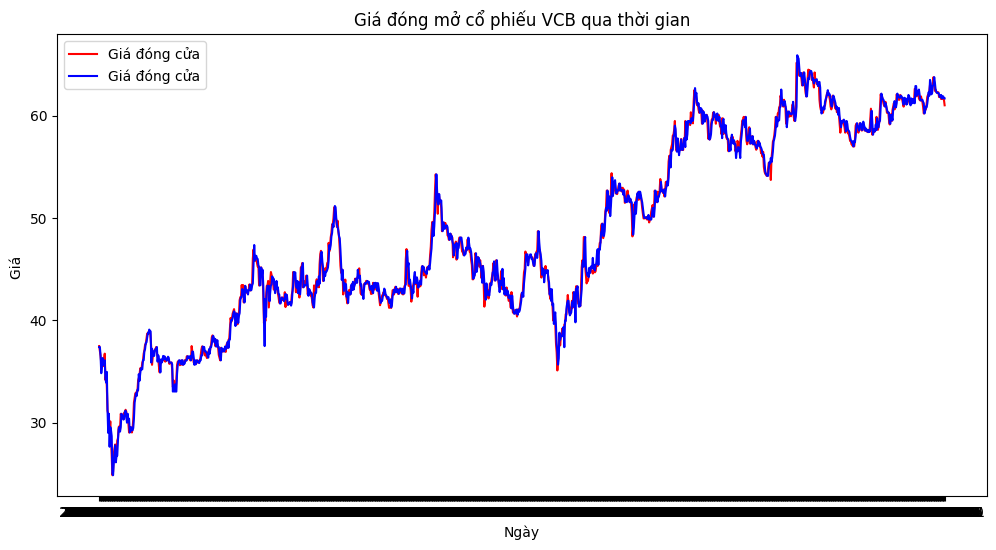

In [ ]:


plt.figure(figsize=(12, 6))
plt.plot(data['time'], data['close'], label='Giá đóng cửa',color='red')
plt.plot(data['time'], data['open'], label='Giá đóng cửa',color='blue')
plt.xlabel('Ngày')
plt.ylabel('Giá ')
plt.legend()
plt.title('Giá đóng mở cổ phiếu VCB qua thời gian')
plt.show()

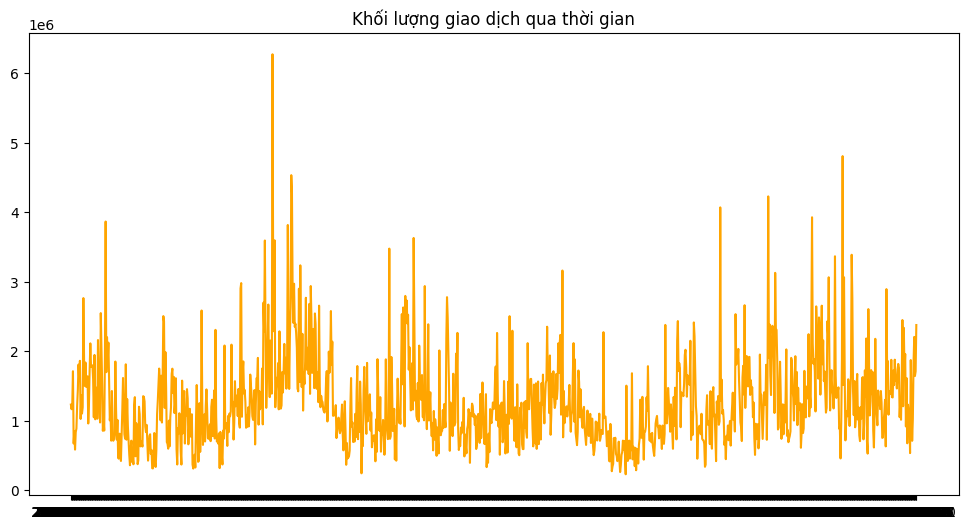

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['time'], data['volume'], label='Khối lượng giao dịch',color='orange')

plt.title('Khối lượng giao dịch qua thời gian')
plt.show()

Chuẩn bị dữ liệu


In [ ]:
data['time'] = pd.to_datetime(data['time'])

stock_close = data['close']
# tạo 1 dataset có dữ liệu kiểu mảng 2 chiều ( matrix có 1 cột trong trường hợp này )
dataset = stock_close.values.reshape(-1, 1)
# số lượng dữ liệu training
train_len = int(np.ceil(len(dataset) * 0.8))
# tiền xử lý dữ liệu
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)
train_data = scaled_data[0:train_len]
X_train,y_train = [],[]

# X_train[0] = dữ liệu từ ngày i ( giá trị đầu = 60) - 60 = 0 tới trước i
#tức là giá trị từ ngày 0-59 ( tương đương ngày 1-60) y là ngày tiếp theo )
#y là ngày tiếp theo tức ngày 61
for i in range(60,len(train_data)):
  X_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
# chuyển sang numpy
X_train = np.array(X_train)
y_train = np.array(y_train)
# M ng: (samples, time_steps, features)
# dữ liệu hiện tại có dạng  ( độ dài,dữ liệu ) thêm 1 cột số 1 đại diện cho số lượng đặc trưng ( ở đây chỉ có 1 đặc trưng )
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))






Build mô hình LSTM


In [ ]:
from keras import Sequential, Input, layers
from keras.metrics import MeanAbsolutePercentageError, RootMeanSquaredError

# tạo  1 model tuần tự ( tức xử lý dữ liệu từ layer 1 sang layer 2....)
# có 5 layer
# layer 1 là layer LSTM để xử lý dữ liêu thời gian, có 64 memory cell ( dùng để học đặc ), return_sequences=True để trả về chuỗi tập hợp thông tin vector đặc trưng từng time step
# layer 2 gói gọn toàn bộ vào 1 vector đặc trưng
# layer 3 xử lý
# layer 4 ngẫu nhiên bỏ 50% neuron tránh bị
# layer 5 trả 1 kết quả
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1)
])

model.summary()

model.compile(
    optimizer="adam",
    loss="mae",
    metrics=[
        MeanAbsolutePercentageError(name="mape"),
        RootMeanSquaredError(name="rmse")
    ]
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

Tạo dữ liệu test



In [ ]:


# chuẩn bị dữ liệu test
test_data = scaled_data[train_len - 60:]
X_test,y_test = [],dataset[train_len:]
for i in range(60,len(test_data)):
  X_test.append(test_data[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

train mô hình

In [ ]:
from keras.callbacks import EarlyStopping
#Batch size = số mẫu dữ liệu mà mô hình xử lý trước khi cập nhật trọng số một lần.,  Epoch = số lần mô hình đi qua toàn bộ dữ liệu huấn luyện một lần.
early_stop = EarlyStopping(
    monitor='loss',   # theo dõi loss trên tập validation
    patience=10,          # nếu 10 epoch liên tiếp không cải thiện thì dừng
    restore_best_weights=True
)

#training = model.fit(X_train,y_train,epochs=100, batch_size=16, callbacks=[early_stop])
training = model.fit(X_train,y_train,epochs=100, batch_size=64, callbacks=[early_stop])



Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.4751 - mape: 89.1641 - rmse: 0.5752
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.2152 - mape: 82.4009 - rmse: 0.2813
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.1854 - mape: 63.7098 - rmse: 0.2386
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.1596 - mape: 50.7600 - rmse: 0.2015
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1535 - mape: 55.5660 - rmse: 0.1986
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1563 - mape: 58.4591 - rmse: 0.2041
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1437 - mape: 46.7331 - rmse: 0.1884
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1387 - mape: 52.2504 - rmse: 0.1816
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1311 - mape: 42.5339 - rmse: 0.1689
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1400 - mape: 53.3563 - rmse: 0.1801
Epoch 11/100
15/1

In [ ]:
# Xem tất cả keys có trong lịch sử
print(training.history.keys())

# Lấy giá trị cuối cùng của từng metric
final_loss = training.history["loss"][-1]
final_mape = training.history["mape"][-1]
final_rmse = training.history["rmse"][-1]

print("Final loss (MAE):", final_loss)
print("Final MAPE:", final_mape)
print("Final RMSE:", final_rmse)


dict_keys(['loss', 'mape', 'rmse'])
Final loss (MAE): 0.09791463613510132
Final MAPE: 29.758380889892578
Final RMSE: 0.12889093160629272


Kết quả, so sánh

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


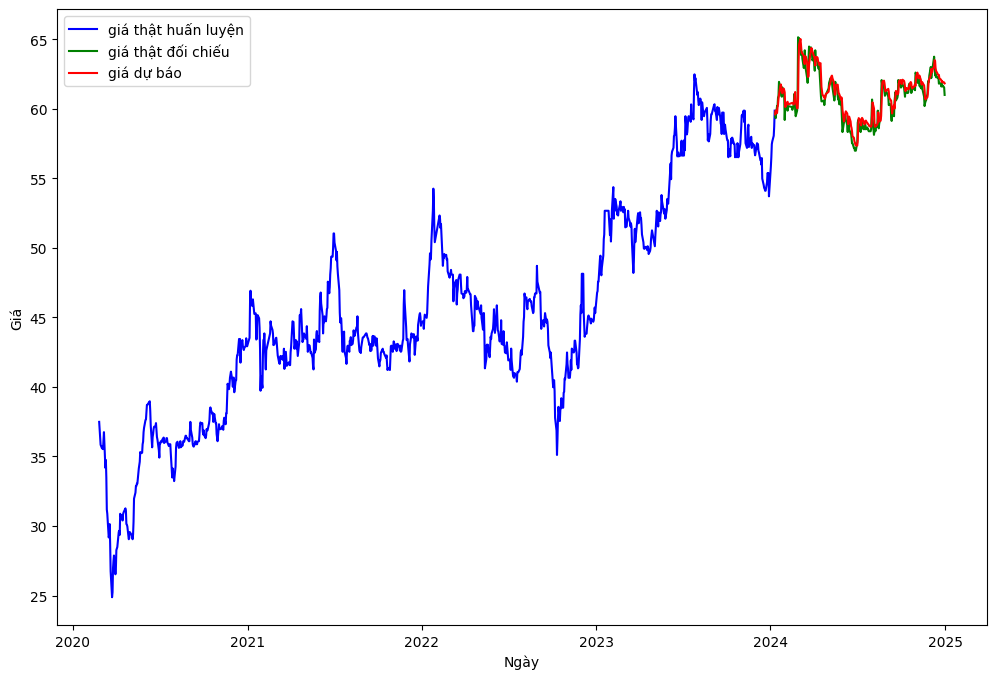

In [ ]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

train = data[:train_len]
test = data[train_len:]
test= test.copy()
test['Predictions'] = predictions

plt.figure(figsize=(12,8))
plt.plot(train['time'],train['close'],label='giá thật huấn luyện', color = 'blue' )
plt.plot(test['time'],test['close'],label='giá thật đối chiếu ', color = 'green' )
plt.plot(test['time'],test['Predictions'],label='giá dự báo ', color = 'red' )
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.legend()
plt.show()

